<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - Iscte <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>

<font size="3"> Afonso Fareleiro - Armando Ferreira - Tomás Carvalho </font>
  
<font size="3"> Group 12 - 'MU' Micron Technology, Inc 

# RL for algorithmic trading

In [2]:
# import libraries

import yfinance as yf  # import data from web (financial time series)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  ## interactive data visualization

# high-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [7]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
data = mu.history(start="2019-01-01", end="2023-09-30")

data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1195 entries, 2019-01-02 00:00:00-05:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1195 non-null   float64
 1   High          1195 non-null   float64
 2   Low           1195 non-null   float64
 3   Close         1195 non-null   float64
 4   Volume        1195 non-null   int64  
 5   Dividends     1195 non-null   float64
 6   Stock Splits  1195 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 74.7 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-25 00:00:00-04:00,68.176264,69.074767,67.497396,68.465782,14900000,0.0,0.0
2023-09-26 00:00:00-04:00,67.856800,68.935003,67.477428,67.826851,12752500,0.0,0.0
2023-09-27 00:00:00-04:00,68.006551,68.735331,66.638830,68.096397,20852300,0.0,0.0
2023-09-28 00:00:00-04:00,65.860130,66.978259,63.723694,65.091408,46749800,0.0,0.0
2023-09-29 00:00:00-04:00,66.249478,68.615533,66.249478,67.916695,24307500,0.0,0.0


<Axes: xlabel='Date'>

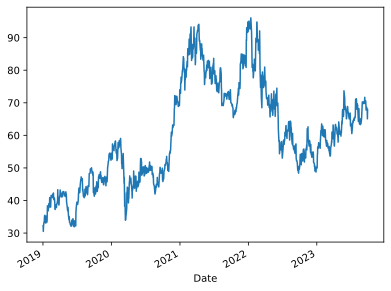

In [5]:
# Daily close price data for MU
data.Close.plot()

## 2. Calculate returns, expected mean returns and risk

In [30]:
# Asset Returns/Rate of Returns: the cumulative daily rate of return is useful to determine /
#                                   the value of an investment at regular intervals.
data_close = data[['Close']]
data_close.columns = ['MU']

returns = np.log(data_close / data_close.shift(1))
returns = returns.dropna()

# Expected Mean Returns
mean_returns = returns.mean()

# Volatility: market volatility is defined as the standard deviation of prices/returns.
vol = returns.std()

# Gain-Loss Ratio (GLR) represents the relative relationship of trades with a positive /
#                                       return and trades with a negative return
glr = returns[returns['MU'] > 0].sum() / returns[returns['MU'] < 0].sum().abs()

# Sharpe Ratio (SR) is the amount of excess return over the risk-free rate as the relevant measure of risk.
## rf is daily risk free rate.
# rf = (1.02 ** (1 / 360)) - 1

risk_free_rate = 0
sr = (mean_returns - risk_free_rate) / vol

# Compound Annual Growth Rate (CAGR)
cumulative_returns = returns.cumsum()
num_trading_days = len(returns)
cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1

# Variance
var = returns.var() * 252

# CVAR
cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

# See metrics in table format
data_summary = pd.DataFrame({
    'Mean Returns': mean_returns,
    'Volatility': vol,
    'Gain-Loss Ratio (GLR)': glr,
    'Sharpe Ratio (SR)': sr,
    'CAGR': cagr,
    'Variance': var,
    'CVAR': cvar
})

data_summary


,Mean Returns,Volatility,Gain-Loss Ratio (GLR),Sharpe Ratio (SR),CAGR,Variance,CVAR
MU,0.000624,0.029188,1.059818,0.02138,-0.060209,0.214685,-16.05826


## 3. Define statistical trading strategy (at least one, maximum 2)

In [ ]:
# Exponential moving average (EMA) strategy
def ema_strategy(data):
    # Define your trading strategy based on the historical data
    # Example: Buy when the 10-day moving average is above the 20-day moving average, sell otherwise
    signals = pd.DataFrame(index=data.index)

    # EMA for 10 and 20 - day windows
    signals['ema_short'] = data['Close'].ewm(span = 10, adjust = False).mean()
    signals['ema_long'] = data['Close'].ewm(span = 50, adjust = False).mean()
                         
    # Define a crossover strategy
    signals['bullish'] = 0.0
    signals['bullish'] = np.where(signals['ema_short'] > signals['ema_long'], 1.0, 0.0)
    signals['crossover'] = signals['bullish'].diff()

    return signals

<class 'pandas.core.series.Series'>
DatetimeIndex: 1195 entries, 2019-01-02 00:00:00-05:00 to 2023-09-29 00:00:00-04:00
Series name: crossover
Non-Null Count  Dtype  
--------------  -----  
1194 non-null   float64
dtypes: float64(1)
memory usage: 51.0 KB


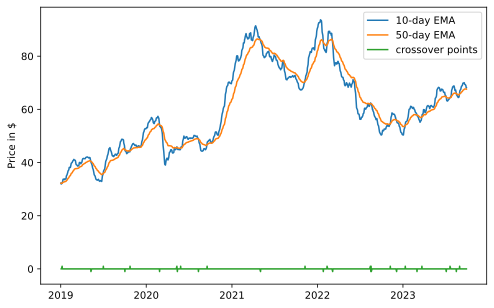

In [77]:
# Plot strategy

ema = ema_strategy(data)

ema.crossover.info()
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(ema['ema_short'], label='10-day EMA')
ax.plot(ema['ema_long'], label='50-day EMA')
ax.plot(ema['crossover'], label='crossover points')
ax.legend(loc='best')
ax.set_ylabel('Price in $')

start_date = '2021-01-01'
end_date = '2022-12-31'

# Plot moving averages
# fig, ax = plt.subplots(figsize=(8, 5))

# ax.plot(data.loc[start_date:end_date].index, data.loc[start_date:end_date, 'Close'], label='MU Close Price')
# ax.plot(ema.ema_short.loc[start_date:end_date].index, ema.ema_short.loc[start_date:end_date, 'Close'], label='20-days SMA')
# ax.plot(ema.ema_long.loc[start_date:end_date].index, ema.ema_long.loc[start_date:end_date, 'Close'], label='10-days SMA')

# ax.legend(loc='best')
# ax.set_ylabel('Price in $')

## 4. Evaluate the efficacy of the trading strategy

In [16]:
'''Insert code here'''

'Insert code here'

## 5. Use at least one reinforcement learning algorithm for trading the assets (Q-learning, deep Q-learning)

In [17]:
'''Insert code here'''

'Insert code here'

## 6. Evaluate the efficacy of the trading strategy

In [18]:
'''Insert code here'''

'Insert code here'

## 7. Fine-tune your algorithms

In [19]:
'''Insert code here'''

'Insert code here'

## 8. Compare and interpret the results

In [20]:
'''Insert code here'''

'Insert code here'